In [1]:
import warnings
warnings.filterwarnings('ignore')

from active_tester import ActiveTester
from active_tester.estimators.naive import Naive
from active_tester.estimators.learned import Learned
from active_tester.query_strategy.random import Random
from sklearn.metrics import accuracy_score

import active_tester
import sys
sys.path.append("../")
from simulate_dataset import TestDataset
from sklearn.metrics import accuracy_score
from active_tester.label_estimation.methods import no_oracle, oracle_one_label, oracle_multiple_labels
import seaborn as sns
import numpy as np

## Overview

In this notebook, we discuss a few of the different item query strategies available in the package and compare them in a few scenarios.  Most of the query strategies are inspired by ideas from Active Learning.  Specifically, we will discuss queries based on:
- random sampling
- the uncertainty of the classifier
- the uncertainty of the noisy labels (provided there is more than 1 per item)
- the discrepancy between the classifier predicted probabilities and the ground truth estimates

The package also includes two more complex item query strategies that will be discussed in their own notebooks.  These strategies are based on
- enforcing diversity amongst the queried items in the feature space (see DPP)
- constructing "prototypical" examples for each class (see Prototypical Vetting)

## Random sampling

The random sampling strategy is simple.  From the set of currently unvetted items, select items uniformly at random, without replacement.

When paired with the learned estimator, random sampling is quite effective.

In [2]:
sample_dataset = TestDataset(num_samples=10000, 
                             num_features=10, 
                             num_informative_features=5, 
                             num_classes=4, 
                             num_clusters_per_class=4)
sample_dataset.test(num_experts=1,expert_accuracy=0.6)
X_test = sample_dataset.X
model = sample_dataset.model
y_noisy = sample_dataset.y_noisy
y_true = sample_dataset.y_true

In [3]:
class_names = ['0','1','2', '3']
active_test = ActiveTester(estimator=Learned(metric=accuracy_score, 
                                             estimation_method=oracle_multiple_labels), 
                                         query_strategy=Random())
active_test.standardize_data(X=X_test, 
                             classes=class_names, 
                             Y_noisy=y_noisy, 
                             Y_ground_truth=y_true)

active_test.gen_model_predictions(model)
active_test.query_vetted(interactive=False, budget=100)
active_test.test()
result = active_test.get_test_results()
print(result['tester_metric'])

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
0.64465872


## Classifier Uncertainty

The idea behind querying items according to the uncertainty of the classifier is that we are least sure about its performance on the items for which it is not certain.  We quantify uncertainty based on the entropy of the distribution of predicted probabilities $p(z|x)$.  Items for which most of the probability is placed on a single label will be the least likely to be chosen, while items for which the probability mass is more evenly distributed across the classes will be more likely to be chosen.  Specifically

$$
p_i \propto -\sum_{j \in C}{p(z_i=j|x)\ln(p(z_i=j|x))}
$$

To use this sampling strategy, set the `option` parameter to `sample`.  We also provide two variants of this strategy.  The first simply queries the items with the highest probability defined above (rather than randomly sampling according to that distribution).  To use this, set the `option` parameter to `greedy`.  The second smoothes the distribution above by mixing it with a uniform distribution.  To use this, set the `option` parameter to `smoothed`.

In [4]:
from active_tester.query_strategy.classifier_uncertainty import ClassifierUncertainty

class_names = ['0','1','2', '3']
active_test = ActiveTester(estimator=Learned(metric=accuracy_score, 
                                             estimation_method=oracle_multiple_labels), 
                           query_strategy=ClassifierUncertainty(option='sample'))
active_test.standardize_data(X=X_test, 
                             classes=class_names, 
                             Y_noisy=y_noisy, 
                             Y_ground_truth=y_true)

active_test.gen_model_predictions(model)
active_test.query_vetted(interactive=False, budget=100, batch_size=10)
active_test.test()
result = active_test.get_test_results()
print(result['tester_metric'])

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
0.62504604


## Noisy label uncertainty

The idea behind querying according to the uncertainty of the noisy labels is that we will learn the most from the vetted labels if we update those that have the most disagreement between the experts.  This strategy only makes sense if you have more than one noisy label per item (as would be common in crowdsourcing).  To define this uncertainty, we will compute the entropy over the probability distribution induced by the votes of the noisy labels.  Specifically,

$$
p_i \propto -\sum_{j \in C}{\frac{V_{ij}}{N_i}\ln\left(\frac{V_{ij}}{N_i}\right)}
$$

where $V_{ij}$ is the number of votes for class $j$ on item $i$ and $N_i$ is the total number of votes for on item $i$.  Again, we provide two variants of this strategy.  The first simply queries the items with the highest probability defined above (rather than randomly sampling according to that distribution).  The second smoothes the distribution above by mixing it with a uniform distribution.

In [5]:
sample_dataset = TestDataset(num_samples=10000, 
                             num_features=10, 
                             num_informative_features=5, 
                             num_classes=4, 
                             num_clusters_per_class=4)
sample_dataset.test(num_experts=5,expert_accuracy=0.6)
X_test = sample_dataset.X
model = sample_dataset.model
y_noisy = sample_dataset.y_noisy
y_true = sample_dataset.y_true

In [6]:
from active_tester.query_strategy.noisy_label_uncertainty import LabelUncertainty

class_names = ['0','1','2', '3']
active_test = ActiveTester(estimator=Learned(metric=accuracy_score, 
                                             estimation_method=oracle_multiple_labels), 
                           query_strategy=LabelUncertainty(option='sample'))
active_test.standardize_data(X=X_test, 
                             classes=class_names, 
                             Y_noisy=y_noisy, 
                             Y_ground_truth=y_true)

active_test.gen_model_predictions(model)
active_test.query_vetted(interactive=False, budget=100, batch_size=10)
active_test.test()
result = active_test.get_test_results()
print(result['tester_metric'])

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
0.63303228


## Most Common Mistake

This strategy aims to choose the items for which there is the largest discrepancy between our current understanding (the estimated ground truth returned by one of the label estimation methods) and the classifier's predictions.  We define this discrepancy as the one norm of the difference between the probabilities.    Specifically,

$$
p_i \propto \sum_{j\in C}{|p(z_i=j|x) - g(z_i=j)|},
$$

where $g$ represents label estimation method.
Note that the estimated ground truth $g$ is updated after every `batch_size` samples.  Small batch sizes, of course, will require many updates to the estimated ground truth, which could be expensive, depending on the dataset.

Again, we provide two variants of this strategy.  The first simply queries the items with the highest probability defined above (rather than randomly sampling according to that distribution).  The second smoothes the distribution above by mixing it with a uniform distribution.

In [7]:
from active_tester.query_strategy.MCM import MCM

class_names = ['0','1','2', '3']
active_test = ActiveTester(estimator=Learned(metric=accuracy_score, 
                                             estimation_method=oracle_multiple_labels), 
                           query_strategy=MCM(estimation_method=oracle_multiple_labels, 
                                                            option='sample'))
active_test.standardize_data(X=X_test, 
                             classes=class_names, 
                             Y_noisy=y_noisy, 
                             Y_ground_truth=y_true)

active_test.gen_model_predictions(model)
active_test.query_vetted(interactive=False, budget=100, batch_size=10)
active_test.test()
result = active_test.get_test_results()
print(result['tester_metric'])

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
0.63527016


## Query strategies compared

Below, we compare the query strategies discussed above.

In [8]:
to_plot = sample_dataset.compare_estimator_query(estimators=['Learned'], 
                                       query_strategies=['Random',
                                                        'Classifier Uncertainty Sample',
                                                        'Noisy Label Uncertainty Sample',
                                                        'MCM Sample'],
                                       sample_sizes=[100,200,300,400,500],
                                       estimation_method=['Oracle Multiple Labels'],
                                       num_iterations=5)

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "200" to "196"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "200" to "196"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "200" to "196"
Beginning preprocessing to fi

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "400" to "396"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "400" to "396"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
Beginning preprocessing t

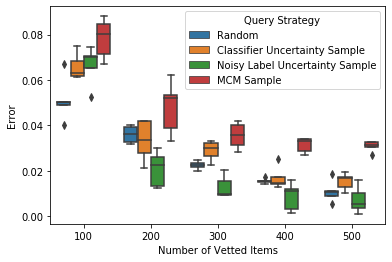

In [9]:
sns.boxplot(x='Number of Vetted Items', y='Error', hue='Query Strategy', data=to_plot)